In [1]:
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skimage
from skimage.io import imread, imsave
import collections

cuda = torch.cuda.is_available()

torch.manual_seed(0)
if cuda:
    torch.cuda.manual_seed(0)

In [2]:
# download Invasive Ductal Carcinoma dataset
# https://academictorrents.com/details/e40bd59ab08861329ce3c418be191651f35e2ffa
import academictorrents as at
datazipfile = at.get("e40bd59ab08861329ce3c418be191651f35e2ffa")
print(datazipfile)

Torrent name: IDC_regular_ps50_idx5.zip, Size: 1644.89MB
/Users/ieee8023/.academictorrents-datastore/IDC_regular_ps50_idx5.zip


In [3]:
!mkdir -p ./data/
!unzip -o -q -d ./data/ $datazipfile

In [4]:
# credit: Jordi_de_la_Torre
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight   

In [5]:
transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train = torchvision.datasets.ImageFolder('./data/10253/', transform=transform)
print(collections.Counter(np.asarray(train.samples)[:,1]))
valid = torchvision.datasets.ImageFolder('./data/10254/', transform=transform)
print(collections.Counter(np.asarray(valid.samples)[:,1]))

batch_size = 128

# balance classes so training works

train_weights = make_weights_for_balanced_classes(train.imgs, len(train.classes))
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_weights, batch_size)
train_loader = dataloader.DataLoader(train, batch_size=batch_size, sampler=train_sampler)

valid_weights = make_weights_for_balanced_classes(valid.imgs, len(valid.classes))
valid_sampler = torch.utils.data.sampler.WeightedRandomSampler(valid_weights, batch_size)
valid_loader = dataloader.DataLoader(valid, batch_size=1024, sampler=valid_sampler)


Counter({'0': 479, '1': 70})
Counter({'0': 772, '1': 76})


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=3,
                stride=2,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=2,
                kernel_size=10,
                stride=2,
                padding=0,
            )
        )

    def forward(self, x):
        x = self.conv1(x)
        return x

In [7]:
model = CNN()
if cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
evaluate_x, evaluate_y = next(iter(valid_loader))
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()


In [9]:
EPOCHS = 50
losses = []

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):

        if cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        y_pred = model(data) 

        loss = F.cross_entropy(y_pred.view(-1,2), target)
        losses.append(loss.cpu().data.item())
        loss.backward()
        optimizer.step()

        if False:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data.item()))

    model.eval()
    output = model(evaluate_x).view(-1,2)
    pred = output.data.max(1)[1] #max along dim 1 and then take the 2nd var returned which is the bin
    max_bin = pred.eq(evaluate_y.data).cpu()
    valid_accuracy = max_bin.sum().item()*1./max_bin.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Valid Accuracy: {:.2f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data.item(),
        valid_accuracy*100.0))

 Train Epoch: 1/50 [549/549 (0%)]	Loss: 0.691727	 Valid Accuracy: 53.91%
 Train Epoch: 2/50 [549/549 (0%)]	Loss: 0.727500	 Valid Accuracy: 53.91%
 Train Epoch: 3/50 [549/549 (0%)]	Loss: 0.689244	 Valid Accuracy: 66.41%
 Train Epoch: 4/50 [549/549 (0%)]	Loss: 0.680886	 Valid Accuracy: 69.53%
 Train Epoch: 5/50 [549/549 (0%)]	Loss: 0.669237	 Valid Accuracy: 77.34%
 Train Epoch: 6/50 [549/549 (0%)]	Loss: 0.643313	 Valid Accuracy: 67.19%
 Train Epoch: 7/50 [549/549 (0%)]	Loss: 0.676496	 Valid Accuracy: 84.38%
 Train Epoch: 8/50 [549/549 (0%)]	Loss: 0.648090	 Valid Accuracy: 53.91%
 Train Epoch: 9/50 [549/549 (0%)]	Loss: 0.660388	 Valid Accuracy: 68.75%
 Train Epoch: 10/50 [549/549 (0%)]	Loss: 0.656836	 Valid Accuracy: 84.38%
 Train Epoch: 11/50 [549/549 (0%)]	Loss: 0.577036	 Valid Accuracy: 82.03%
 Train Epoch: 12/50 [549/549 (0%)]	Loss: 0.587948	 Valid Accuracy: 78.91%
 Train Epoch: 13/50 [549/549 (0%)]	Loss: 0.609789	 Valid Accuracy: 84.38%
 Train Epoch: 14/50 [549/549 (0%)]	Loss: 0.5989

In [10]:
test_image = imread("10279_500_f00182_original.jpg")
test_image = torch.FloatTensor(test_image)
test_image = test_image.permute([2,0,1]) # move color channel 

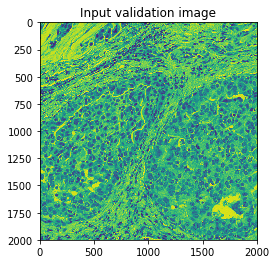

In [11]:
plt.title("Input validation image")
plt.imshow(test_image[0].numpy());

In [12]:
# run in a fully convolutional way
test_output = model(test_image.unsqueeze(0)) 

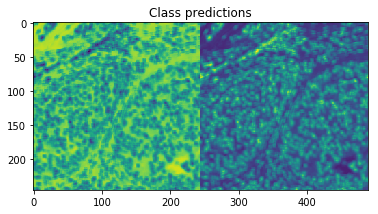

In [13]:
plt.title("Class predictions");
plt.imshow(np.concatenate(test_output.detach().numpy()[0], axis=1));

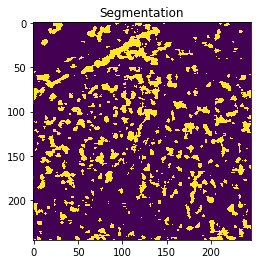

In [14]:
plt.title("Segmentation");
plt.imshow(test_output.detach().max(1)[1][0]);